## OTEC Modeling. Idealized Rankine Cycle

**States**
1. Exiting the Evaporator
2. Exiting the Turbine/Generator
3. Exiting the Condensor
4. Exiting the Pump/Compressor


**Assumptions**
* No superheating/cooling. Fluid leaving the evaporator is a saturated vapor. Fluid leaving the condensor is a saturated liquid. 
* Gross power output of the turbine is 125kW
* Temperature of cold ocean water is 5C
* Temperature of hot ocean water is 30C
* The working fluid can only be within 5C of either hot/cold fluid source
* Pump and Turbine are isentropic
* Condenser is a isobaric and isothermal process
* Evaporator is a isobaric process


**Next Steps**
* Model pressure drop across evaporator and condenser (Vera says 0.0015 bar)
* Model isentropic inefficiencies in turbine and pump

**Questions**
* Because the specific heat of water is different than most working fluids, we can't just compare the end temperatures right? 1 unit of temperature change in water represents a lot more energy than 1 unit of temperature change in the working fluid. How do we reconcile the energy based adiabatic analysis with the simplified temperature analysis? 

In [1]:
import CoolProp.CoolProp as CP
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors



class State:
    def __init__(self, t, p, h, s, q=None):
        self.t = t
        self.p = p
        self.h = h
        self.s = s
        self.q = q
        

def calc_state(p1, p2, sub='NH3'):
    # Assumes no superheating/cooling (q1 = 1, q3 = 0)

    # State 1: Exiting Evaporator
    q1 = 1
    h1 = CP.PropsSI('H', 'Q', q1, 'P', p1, sub)
    s1 = CP.PropsSI('S', 'Q', q1, 'P', p1, sub)
    t1 = CP.PropsSI('T', 'Q', q1, 'P', p1, sub)
    state1 = State(t1, p1, h1, s1, q1)

    # State 2: Exiting the turbine
    s2 = s1
    t2 = CP.PropsSI('T', 'S', s2, 'P', p2, sub)
    h2 = CP.PropsSI('H', 'S', s2, 'P', p2, sub)
    q2 = CP.PropsSI('Q', 'S', s2, 'P', p2, sub)
    state2 = State(t2, p2, h2, s2, q2)
    
    # State 3: Exiting Condensor
    q3 = 0
    t3 = t2
    p3 = p2
    h3 = CP.PropsSI('H', 'Q', q3, 'P', p3, sub)
    s3 = CP.PropsSI('S', 'Q', q3, 'P', p3, sub)
    state3 = State(t3, p3, h3, s3, q3)

    # State 4: Exiting Pump
    s4 = s3
    p4 = p1
    h4 = CP.PropsSI('H', 'S', s4, 'P', p4, sub)
    t4 = CP.PropsSI('T', 'H', h4, 'S', s4, sub)
    state4 = State(t4, p4, h4, s4)
    
    return (state1, state2, state3, state4)

### Model Setup

In [2]:
# number of pressure values to sweep
num_p1 = 50
num_p2 = 50

# hot and cold temp limits (with t_pinch = 5)
t_cold = 5 + 273 + 5
t_hot = 30 + 273 - 5

# Pressures to sweep
p1s = np.linspace(4e5, 1.2e6, num_p1)
p2s = np.linspace(4e5, 1.2e6, num_p2)
p1_mesh, p2_mesh = np.meshgrid(p1s, p2s)

# Work from turbine
W_turb = -125e3

# State variables
state1, state2, state3, state4 = calc_state(p1_mesh.ravel(), p2_mesh.ravel(), 'NH3')


### Calculate Invalid States

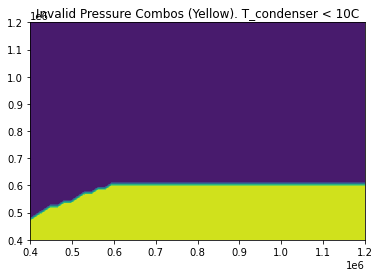

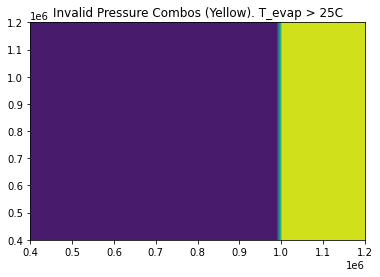

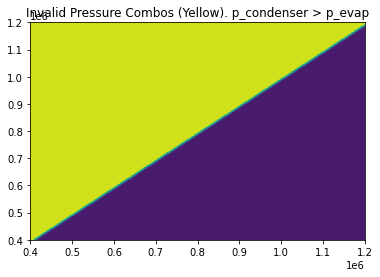

In [3]:
# Invalid because p2 > p1
invalid_p = (p2_mesh / p1_mesh) >= 1
# Invalid because working fluid is colder than resivoir temp + t_pinch
invalid_t_cold = state2.t.reshape(num_p1, num_p2) < t_cold
# invalid because working fluid is hotter than resivoir temp + t_pinch
invalid_t_hot = state1.t.reshape(num_p1, num_p2) > t_hot
invalid_t = np.logical_or(invalid_t_cold, invalid_t_hot)
invalid = np.logical_or(invalid_p, invalid_t)

plt.contourf(p1_mesh, p2_mesh, invalid_t_cold)
plt.title('Invalid Pressure Combos (Yellow). T_condenser < 10C')
plt.figure()
plt.title('Invalid Pressure Combos (Yellow). T_evap > 25C')
plt.contourf(p1_mesh, p2_mesh, invalid_t_hot)
plt.figure()
plt.title('Invalid Pressure Combos (Yellow). p_condenser > p_evap')
plt.contourf(p1_mesh, p2_mesh, invalid_p)


### Calculate mass-flow rate

<ipython-input-4-c4b7c13b6ea7>:4: RuntimeWarning: divide by zero encountered in true_divide
  m_dot_grid = W_turb / (h2_grid - h1_grid)


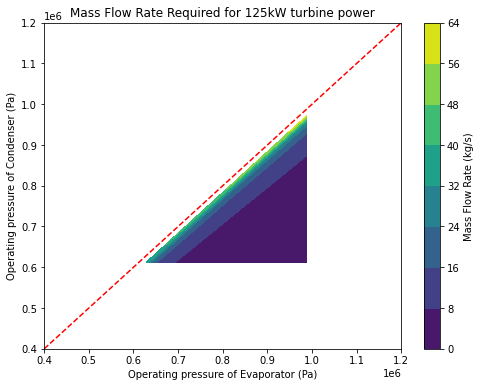

In [4]:
h1_grid = state1.h.reshape(num_p1, num_p2)
h2_grid = state2.h.reshape(num_p1, num_p2)

m_dot_grid = W_turb / (h2_grid - h1_grid)

# filter out invalid and infinite m_dots
m_dot_grid[invalid] = None
m_dot_grid[np.isinf(m_dot_grid)] = None


fig = plt.figure()
plt.contourf(p1_mesh, p2_mesh, m_dot_grid)
plt.title('Mass Flow Rate Required for 125kW turbine power')
plt.xlabel('Operating pressure of Evaporator (Pa)')
plt.ylabel('Operating pressure of Condenser (Pa)')
plt.plot([min(p1s), max(p2s)], [min(p1s), max(p2s)], 'r--')
plt.colorbar(label='Mass Flow Rate (kg/s)')
fig.set_size_inches(8, 6)

### Calculate $W_\text{turbine} / W_\text{pump}$

<ipython-input-5-1b4945c34f78>:5: RuntimeWarning: divide by zero encountered in true_divide
  W_ratio = (h2_grid - h1_grid) / (h4_grid - h3_grid)
<ipython-input-5-1b4945c34f78>:5: RuntimeWarning: invalid value encountered in true_divide
  W_ratio = (h2_grid - h1_grid) / (h4_grid - h3_grid)


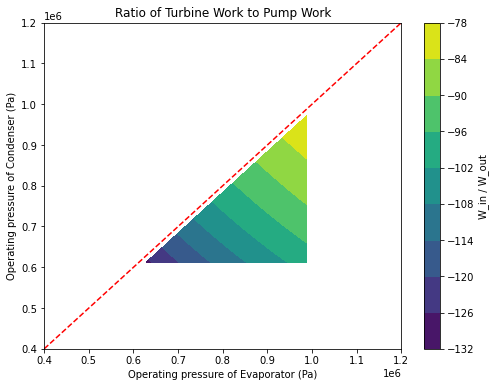

In [5]:
h3_grid = state3.h.reshape(num_p1, num_p2)
h4_grid = state4.h.reshape(num_p1, num_p2)

# Calculates the ratio of W_turb/W_work
W_ratio = (h2_grid - h1_grid) / (h4_grid - h3_grid)
W_ratio[invalid] = None

fig = plt.figure()
plt.contourf(p1_mesh, p2_mesh, W_ratio)
plt.plot([min(p1s), max(p2s)], [min(p1s), max(p2s)], 'r--')
plt.title('Ratio of Turbine Work to Pump Work')
plt.xlabel('Operating pressure of Evaporator (Pa)')
plt.ylabel('Operating pressure of Condenser (Pa)')
plt.colorbar(label='W_in / W_out')
fig.set_size_inches(8, 6)

### Calculate work by pump

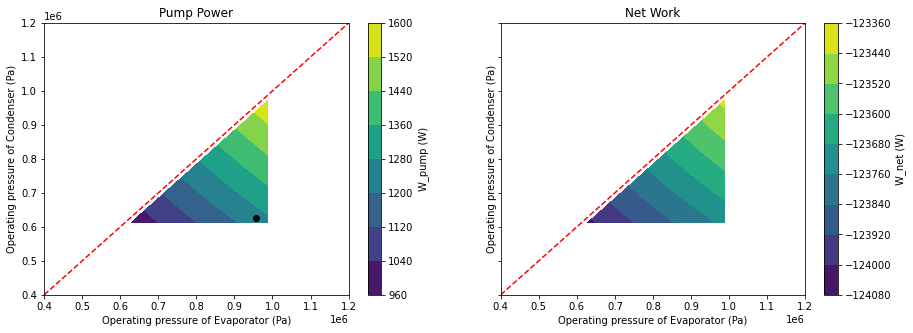

In [6]:
h3_grid = state3.h.reshape(num_p1, num_p2)
h4_grid = state4.h.reshape(num_p1, num_p2)

W_pump = m_dot_grid * (h4_grid - h3_grid)
invalid = (p2_mesh / p1_mesh) > 1
W_pump[invalid] = None

W_net = W_turb + W_pump

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_size_inches(15, 5)

cf_pump = ax1.contourf(p1_mesh, p2_mesh, W_pump)
ax1.plot([min(p1s), max(p2s)], [min(p1s), max(p2s)], 'r--')
ax1.set_title('Pump Power')
ax1.set_xlabel('Operating pressure of Evaporator (Pa)')
ax1.set_ylabel('Operating pressure of Condenser (Pa)')
ax1.scatter(9.57e5, 6.25e5, color='k')
fig.colorbar(cf_pump, ax=ax1, label='W_pump (W)')

cf_ratio = ax2.contourf(p1_mesh, p2_mesh, W_net)
ax2.plot([min(p1s), max(p2s)], [min(p1s), max(p2s)], 'r--')
ax2.set_title('Net Work')
ax2.set_xlabel('Operating pressure of Evaporator (Pa)')
ax2.set_ylabel('Operating pressure of Condenser (Pa)')
fig.colorbar(cf_ratio, ax=ax2, label='W_net (W)')

### Thermal Efficiency

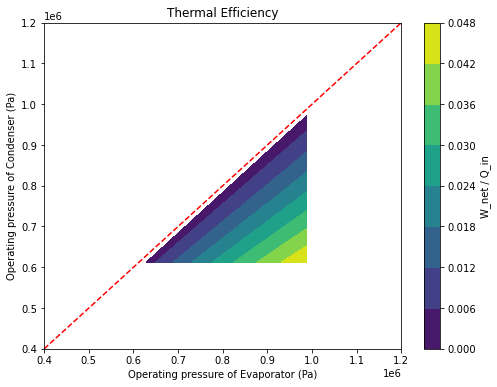

In [7]:
h1_grid = state1.h.reshape(num_p1, num_p2)
h4_grid = state4.h.reshape(num_p1, num_p2)

Q_in = -(h1_grid - h4_grid) * m_dot_grid
Q_in[invalid] = None

fig = plt.figure()
plt.contourf(p1_mesh, p2_mesh, W_net/Q_in)
plt.plot([min(p1s), max(p2s)], [min(p1s), max(p2s)], 'r--')
plt.title('Thermal Efficiency')
plt.xlabel('Operating pressure of Evaporator (Pa)')
plt.ylabel('Operating pressure of Condenser (Pa)')
plt.colorbar(label='W_net / Q_in')
fig.set_size_inches(8, 6)